Модифицировать реализованный ранее алгоритм выравнивания в алгоритм для локального выравнивания (Ватермана-Смита). Алгоритм должен использовать матрицу замен BLOSUM и PAM - сравнить выравнивания с двумя различными матрицами. 

In [39]:
import numpy as np
import Bio
import Bio.SubsMat.MatrixInfo as subMat

gap_fair=10

def create_matrix(str1, str2, fair,sub_matrix):
    
    n=len(str2)+1
    m=len(str1)+1
    
    matrix=np.zeros((n,m))
    saved_path=np.zeros((n,m,2),dtype=np.int64)
    
    for i in range(1,n):
        for j in range(1,m):
            mutation_cost=sub_matrix.get((str2[i-1].upper(),str1[j-1].upper()))
            if mutation_cost==None:
                mutation_cost=sub_matrix.get((str1[j-1].upper(),str2[i-1].upper()))
           
            direction_dict={matrix[i-1,j-1]+mutation_cost : [i-1,j-1]}
            
            if direction_dict.get(matrix[i-1,j]-fair)==None:
                direction_dict[matrix[i-1,j]-fair]=[i-1,j]
            
            if direction_dict.get(matrix[i-1,j]-fair)==None:
                direction_dict[matrix[i-1,j]-fair]=[i-1,j]
                
            if direction_dict.get(matrix[i,j-1]-fair)==None:
                direction_dict[matrix[i,j-1]-fair]=[i,j-1]
            
            if direction_dict.get(0)==None:
                direction_dict[0]=[-1,-1]
             
            matrix[i,j]=np.max(list(direction_dict.keys()))
            saved_path[i,j]=direction_dict[matrix[i,j]]

    return matrix, saved_path

def align(str1,str2,matrix,saved_path):
    
    n=matrix.shape[0]
    m=matrix.shape[1]
    
    aligned_str1, aligned_str2 = "",""
    
    i_max, j_max, max_value=0,0,0
    
    for i in range(n):
        for j in range(m):
            if matrix[i,j]>max_value:
                max_value=matrix[i,j]
                i_max=i
                j_max=j
    
    i_cur,j_cur=i_max,j_max
    i_next,j_next=saved_path[i_cur,j_cur]
    
    aligned_str1+=str1[-1:j_max-1:-1]
    aligned_str2+=str2[-1:i_max-1:-1]
    
    while matrix[i_cur,j_cur]!=0: 
        if i_next==i_cur:
            aligned_str1+=str1[j_cur-1]
            aligned_str2+='-'
        
        if j_next==j_cur:
            aligned_str1+='-'
            aligned_str2+=str2[i_cur-1]
        
        if i_next!=i_cur and j_next!=j_cur:
            aligned_str1+=str1[j_cur-1]
            aligned_str2+=str2[i_cur-1]
            
        i_cur, j_cur=i_next,j_next
        i_next, j_next=saved_path[i_cur,j_cur]
        
    aligned_len=len(aligned_str2)-len(str2[-1:i_max-1:-1])
    aligned_str1+=str1[(0 if j_cur-1<0 else j_cur-1):(0 if j_cur-1<0 else None):-1]
    aligned_str2+=str2[(0 if i_cur-1<0 else i_cur-1):(0 if i_cur-1<0 else None):-1]
    
    indent=len(str2[0:i_cur])-len(str1[0:j_cur])
    unaligned_len=min(len(str2[0:i_cur]),len(str1[0:j_cur]))

    return aligned_str1[::-1],aligned_str2[::-1],max_value,indent,unaligned_len,aligned_len

In [40]:
def smith_waterman(str1,str2,fair,sub_matrix):
    
    matrix,saved_path = create_matrix(str1,str2,fair,sub_matrix)
    aligned_str1,aligned_str2,score,indent,unaligned_len,aligned_len = align(str1,str2,matrix,saved_path)
    
    return aligned_str1,aligned_str2,score,indent,unaligned_len,aligned_len

def do_algorithm(str1,str2,fair,sub_matrix):
    align1,align2,score,indent,unaligned_len,aligned_len=smith_waterman(str1,str2,fair,sub_matrix)
    
    indent_str1=""
    indent_str2=""
    print("Chain 1: ",indent_str1,str1)
    print("Chain 2: ",indent_str2,str2)
    print("Score: ",score)
    
    if indent>=0:
        indent_str1+=" "*indent
    else:
        indent_str2+=" "*abs(indent)
        
    print("Align 1: ",indent_str1,align1)
    
    #10 spaces for phrase "Align 1: "
    separator=" "*11
    separator+=" "*(abs(indent)+unaligned_len)

    for i in range(abs(indent)+unaligned_len, abs(indent)+unaligned_len+aligned_len):
        if align1[i-(indent if indent>0 else 0)]==align2[i -(abs(indent) if indent<0 else 0)]:
            separator+='|'
        else:
            separator+='.'
    
    print(separator)
    print("Align 2: ",indent_str2,align2)

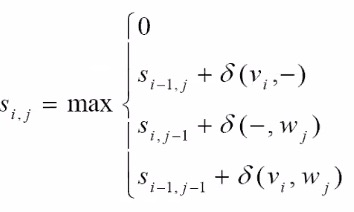

BLOSUM62

In [35]:
str1="ACGTCATCA"
str2="TAGTGTCA"
do_algorithm(str1,str2, gap_fair,subMat.blosum62)

Chain 1:   ACGTCATCA
Chain 2:   TAGTGTCA
Score:  24.0
Align 1:     ACGTCATCA
               ||||
Align 2:   TAGTGTCA


In [36]:
str1="GAAATGAA"
str2="GACTAGGA"
do_algorithm(str1,str2, gap_fair,subMat.blosum62)

Chain 1:   GAAATGAA
Chain 2:   GACTAGGA
Score:  20.0
Align 1:   GAAATGAA
           ||...|.|
Align 2:   GACTAGGA


PAM

In [37]:
str1="ACGTCATCA"
str2="TAGTGTCA"
do_algorithm(str1,str2, gap_fair,subMat.pam60)

Chain 1:   ACGTCATCA
Chain 2:   TAGTGTCA
Score:  26.0
Align 1:     ACGTCATCA
               ||||
Align 2:   TAGTGTCA


In [38]:
str1="GAAATGAA"
str2="GACTAGGA"
do_algorithm(str1,str2, gap_fair,subMat.pam60)

Chain 1:   GAAATGAA
Chain 2:   GACTAGGA
Score:  19.0
Align 1:   GAAATGAA
           ||...|.|
Align 2:   GACTAGGA


МНОЖЕСТВЕННОЕ ВЫРАВНИВАНИЕ

In [14]:
from Bio import AlignIO
align = AlignIO.read("input.txt", "clustal")
print(align)

SingleLetterAlphabet() alignment with 2 rows and 338 columns
MFQAFPGDYDSGSRCSSSPSAESQYLSSVDSFGSPPTAAASQEC...LAL FOSB_MOUSE
MFQAFPGDYDSGSRCSSSPSAESQYLSSVDSFGSPPTAAASQEC...LAL FOSB_HUMAN
